In [11]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, classification_report)
from statannotations.Annotator import Annotator
from biom import load_table
from matplotlib_venn import venn2

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Load data

In [12]:
#load rpca results
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord.txt')
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord.txt')
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord.txt')
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord.txt')
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord.txt')
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord.txt')
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

## Define functions

In [13]:
def rf_acc(ord_tables, ord_ids, shared_mt, cat_of_interest,
           ordination=True, n_folds=10, n_estimators=100, 
           random_state=42, optimize=False, param_grid=None, 
           **kwargs):

    #initialize dataframe to store results
    metrics_df = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                       'Report', 'Optimization'])
    acc_ord = {}
    
    #iterate over ordination tables
    for ord, omic in zip(ord_tables, ord_ids):
        
        if ordination:
            X = ord.samples.copy()
        else: 
            X = ord.copy()
        y = X.index.map(shared_mt[cat_of_interest])
        
        #iterate over folds
        acc_fold = {}
        for fold in ['traintest_{}'.format(i) for i in range(n_folds)]:
            
            #split data into pre-defined train and test sets
            X_group = X.index.map(shared_mt[fold])
            train_index = [True if x == 'train' else False for x in X_group]
            test_index = [True if x == 'test' else False for x in X_group]
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if optimize:
                print(f'Optimizing hyperparameters for {omic}, {fold}...')
                #initialize random forest
                rf = RandomForestClassifier(random_state=random_state)
                #hyperparameter optimization
                grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                                           cv=5, n_jobs=-1, verbose=0, scoring='accuracy')
                grid_search.fit(X_train.values, y_train)
                
                print(f'Best parameters found: {grid_search.best_params_}')
                print(f'Best cross-validation accuracy: {grid_search.best_score_}')

                #save best parameters
                best_params = grid_search.best_params_.copy()
                best_params['best_score'] = grid_search.best_score_

                #get best model
                best_rf = grid_search.best_estimator_

            else:
                #initialize random forest with user-defined parameters
                rf = RandomForestClassifier(n_estimators=n_estimators, 
                                            random_state=random_state, **kwargs)
                rf.fit(X_train.values, y_train)
                best_params = 'None'
                best_rf = rf
            
            #predict on test set
            y_pred = best_rf.predict(X_test)
            #get accuracy and classification report
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred)
            #save results for each fold
            acc_fold[fold] = (accuracy, report, best_params)
        
        #save results for each omic
        acc_ord[omic] = acc_fold

    #create df with metrics
    for omic, acc_fold in acc_ord.items():
        for fold, metrics in acc_fold.items():
            metrics_df = metrics_df.append({'Omic': omic, 'Fold': fold, 
                                            'Accuracy': metrics[0], 
                                            'Report': metrics[1], 
                                            'Optimization': metrics[2]}, 
                                            ignore_index=True)
    return metrics_df

## Ordination-based classification

### RF default params

In [20]:
#FACILITY
acc_ord_facility = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                      ord_gene_module, ord_metabolite, ord_joint],
                          ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                   "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                          shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                          random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_facility.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.797872,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.744681,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.734043,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.765957,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.755319,precision recall f1-score ...,None


In [21]:
#STAGE OF DECOPMPOSITION (ADD 0C)
acc_ord_stage = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_stage.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.446809,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.468085,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.489362,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.457447,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.510638,precision recall f1-score ...,None


In [22]:
#SEASON
acc_ord_season = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                    ord_gene_module, ord_metabolite, ord_joint],
                        ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                 "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                        shared_mt=metadata, cat_of_interest='season', ordination=True, 
                        random_state=42, bootstrap=False, optimize=False, param_grid=None)

display(acc_ord_season.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.787234,precision recall f1-score ...,None
1,18S_RPCA,traintest_1,0.797872,precision recall f1-score ...,None
2,18S_RPCA,traintest_2,0.776596,precision recall f1-score ...,None
3,18S_RPCA,traintest_3,0.723404,precision recall f1-score ...,None
4,18S_RPCA,traintest_4,0.829787,precision recall f1-score ...,None


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:3.363e-01 Stat=4.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

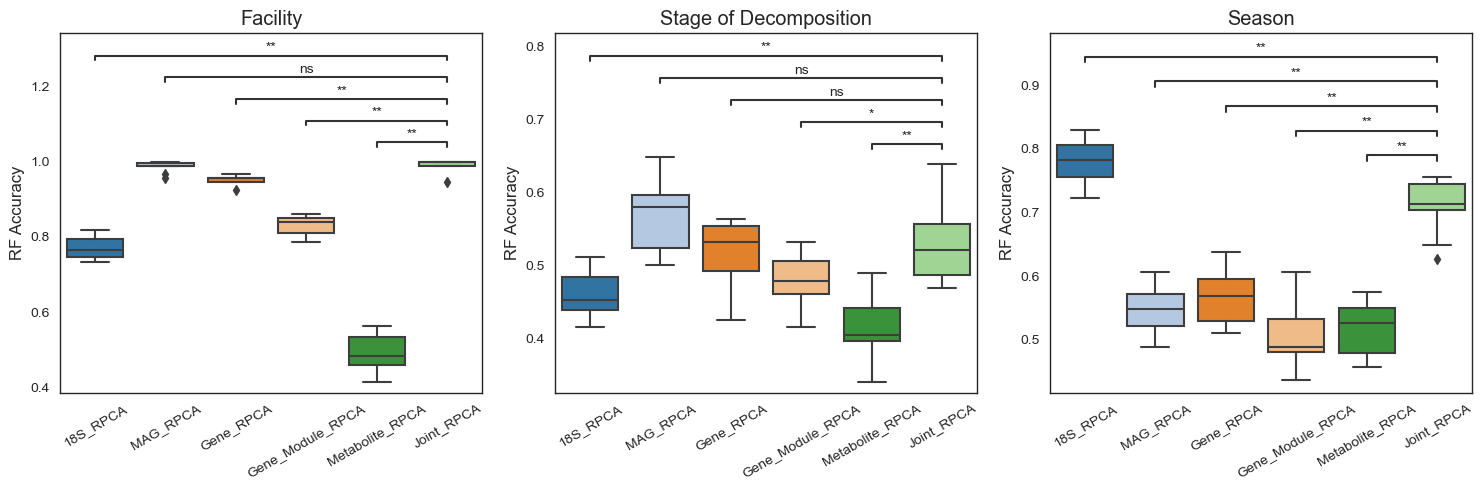

In [23]:
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab20'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility, acc_ord_stage, acc_ord_season],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Hyper-parameter optimization

In [5]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [14]:
#FACILITY
acc_ord_facility_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                          ord_gene_module, ord_metabolite, ord_joint],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                       "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                              shared_mt=metadata, cat_of_interest='facility', ordination=True, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7964285714285715
Optimizing hyperparameters for 18S_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7857142857142858
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8071428571428572
Optimizing hyperparameters for 18S_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.7785714285714286
Optimizing hyperparameters for 18S_RPCA, traintest_4

In [15]:
#save results
#acc_ord_facility_opt.to_csv('../results/joint-rpca/rf_acc_facility_opt.csv', index=False)
display(acc_ord_facility_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.787234,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
1,18S_RPCA,traintest_1,0.744681,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
2,18S_RPCA,traintest_2,0.670213,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
3,18S_RPCA,traintest_3,0.765957,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
4,18S_RPCA,traintest_4,0.797872,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


In [18]:
#STAGE OF DECOMPOSITION (ADD 0C)
acc_ord_stage_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='add_0c_group', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4821428571428572
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for 18S_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.525
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857143
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for 18S_RPCA, traintest_9...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for MAG_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5571428571428572
Optimizing hyperparameters for MAG_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5892857142857144
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6250000000000001
Optimizing hyperparameters for MAG_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_5...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5857142857142856
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for MAG_RPCA, traintest_7...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.5464285714285715
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857144
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_4...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5785714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_7...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5714285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_8...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5678571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5428571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.55
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.5535714285714286
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5607142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5821428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.55
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5428571428571429
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.492857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5250000000000001
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4928571428571429
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4642857142857143
Optimizing hyperparameters for Joint_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5785714285714285
Optimizing hyperparameters for Joint_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.5642857142857144
Optimizing hyperparameters for Joint_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5714285714285715
Optimizing hyperparameters for Joint_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5964285714285713
Optimizing hyperparameters for Joint_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714286
Optimizing hyperparameters for Joint_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5642857142857143


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Optimizing hyperparameters for Joint_RPCA, traintest_6...
Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5571428571428572
Optimizing hyperparameters for Joint_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Joint_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for Joint_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.6285714285714286


In [19]:
#save results
#acc_ord_stage_opt.to_csv('../results/joint-rpca/rf_acc_stage_opt.csv', index=False)
display(acc_ord_stage_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.489362,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
1,18S_RPCA,traintest_1,0.446809,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
2,18S_RPCA,traintest_2,0.521277,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.446809,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
4,18S_RPCA,traintest_4,0.531915,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


In [20]:
for fold in ['traintest_{}'.format(i) for i in range(10)]:
    for group in metadata.add_0c_group.unique():
        print(fold, group)
        print(metadata[metadata.add_0c_group == group][fold].value_counts())
    print()

traintest_0 early
train    36
test     11
Name: traintest_0, dtype: int64
traintest_0 advanced
train    118
test      44
Name: traintest_0, dtype: int64
traintest_0 initial
train    19
test      4
Name: traintest_0, dtype: int64
traintest_0 active
train    107
test      35
Name: traintest_0, dtype: int64

traintest_1 early
train    34
test     13
Name: traintest_1, dtype: int64
traintest_1 advanced
train    126
test      36
Name: traintest_1, dtype: int64
traintest_1 initial
train    17
test      6
Name: traintest_1, dtype: int64
traintest_1 active
train    103
test      39
Name: traintest_1, dtype: int64

traintest_2 early
train    36
test     11
Name: traintest_2, dtype: int64
traintest_2 advanced
train    125
test      37
Name: traintest_2, dtype: int64
traintest_2 initial
train    17
test      6
Name: traintest_2, dtype: int64
traintest_2 active
train    102
test      40
Name: traintest_2, dtype: int64

traintest_3 early
train    35
test     12
Name: traintest_3, dtype: int64
train

In [21]:
#SEASON
acc_ord_season_opt = rf_acc(ord_tables=[ord_18S, ord_mag, ord_gene, 
                                        ord_gene_module, ord_metabolite, ord_joint],
                            ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA",
                                     "Gene_Module_RPCA", "Metabolite_RPCA", "Joint_RPCA"], 
                            shared_mt=metadata, cat_of_interest='season', ordination=True, 
                            n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8214285714285715
Optimizing hyperparameters for 18S_RPCA, traintest_1...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.7428571428571429
Optimizing hyperparameters for 18S_RPCA, traintest_2...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.7571428571428571
Optimizing hyperparameters for 18S_RPCA, traintest_3...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8357142857142857
Optimizing hyperparameters for 18S_RPCA, traintes

In [22]:
#save results
#acc_ord_season_opt.to_csv('../results/joint-rpca/rf_acc_season_opt.csv', index=False)
display(acc_ord_season_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.819149,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
1,18S_RPCA,traintest_1,0.808511,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
2,18S_RPCA,traintest_2,0.765957,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.755319,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
4,18S_RPCA,traintest_4,0.851064,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
MAG_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:4.962e-01 Stat=5.000e+00
18S_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Metabolite_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Joint_RPCA: Wilcoxon test (paired samples), 

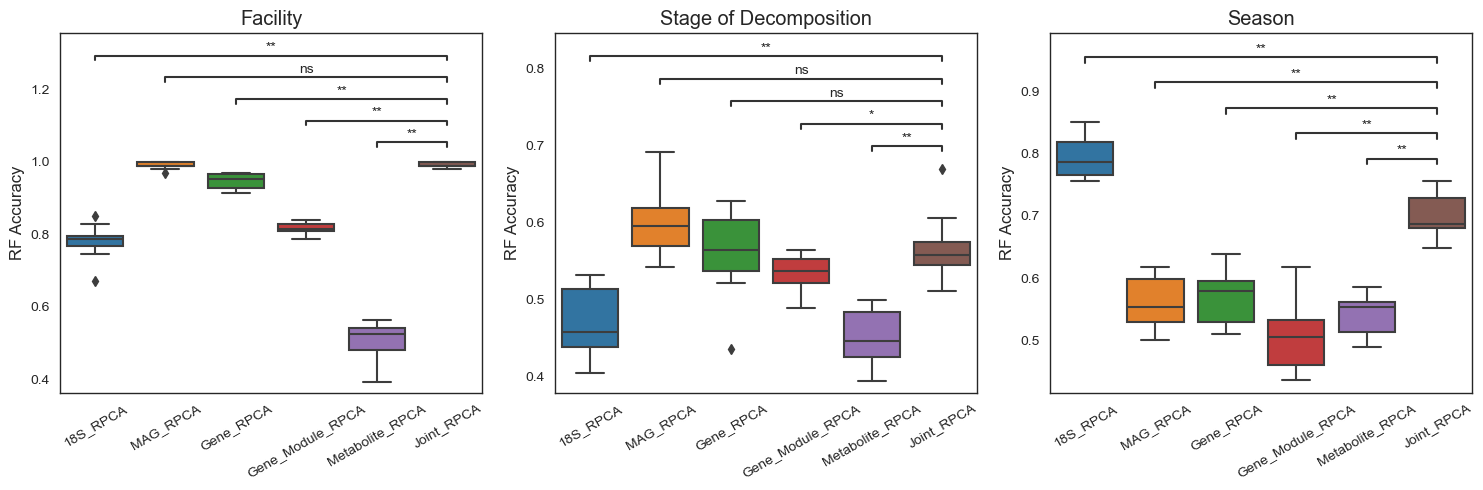

In [26]:
#plot results and run statistical test
order = ['18S_RPCA', 'MAG_RPCA', 'Gene_RPCA', 
         'Gene_Module_RPCA', 'Metabolite_RPCA', 'Joint_RPCA']
stat_pairs = [(omic, "Joint_RPCA") for omic in order[0:-1]]
plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order, 'palette':'tab10'}

fig, axn = plt.subplots(1, 3, figsize=(15, 5))
for ax_, data, title in zip(axn.flatten(), 
                           [acc_ord_facility_opt, acc_ord_stage_opt, acc_ord_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title(title)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Bar plots with detailed groups

In [57]:
# load the results
#acc_ord_season_opt = pd.read_csv('../results/joint-rpca/RF/rf_acc_season_opt.csv')
acc_ord_season_opt = pd.read_csv('../results/joint-rpca/KNN/knn_acc_ord_season.tsv', sep='\t', index_col=0)
display(acc_ord_season_opt.head())
print(acc_ord_season_opt.shape)

,Omic,Fold,Accuracy,Report
0,18S_RPCA,traintest_0,0.808511,precision recall f1-score ...
1,18S_RPCA,traintest_1,0.808511,precision recall f1-score ...
2,18S_RPCA,traintest_2,0.829787,precision recall f1-score ...
3,18S_RPCA,traintest_3,0.819149,precision recall f1-score ...
4,18S_RPCA,traintest_4,0.851064,precision recall f1-score ...


(60, 4)


In [58]:
omic_f1_lst = []
groups = ['fall', 'spring', 'summer', 'winter']
for omic in acc_ord_season_opt.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = acc_ord_season_opt[(acc_ord_season_opt.Omic == omic) & 
                                         (acc_ord_season_opt.Fold == fold)].Report.values[0]
        #get each season's F1-score
        season_f1_lst = []
        for season, i in zip(groups, range(2, 6)):
            season_report = fold_report.split('\n')[i].split(' ')
            season_result = [x for x in season_report if len(x)>0][1:]
            season_f1 = [float(x) for x in season_result][2]
            season_f1_lst.append(season_f1)
        fold_f1_lst.extend(season_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [59]:
#create new dataframe with f1 results
n_omics = len(acc_ord_season_opt.Omic.unique())
n_groups = len(groups)
omic_lst = [[omic] * 10 * n_groups for omic in acc_ord_season_opt.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * n_groups for i in range(10)] * n_omics
fold = np.concatenate(fold)
season = ['fall', 'spring', 'summer', 'winter'] * acc_ord_season_opt.shape[0]

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 'Season': season, 'F1-score': omic_f1_lst})
f1_df.head()

,Omic,Fold,Season,F1-score
0,18S_RPCA,traintest_0,fall,0.84
1,18S_RPCA,traintest_0,spring,0.93
2,18S_RPCA,traintest_0,summer,0.75
3,18S_RPCA,traintest_0,winter,0.58
4,18S_RPCA,traintest_1,fall,0.88


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

fall_Metabolite_RPCA vs. fall_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
spring_Metabolite_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:7.686e-03 Stat=0.000e+00
summer_Metabolite_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:9.766e-03 Stat=3.000e+00
winter_Metabolite_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
spring_Gene_Module_RPCA vs. spring_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
summer_Gene_Module_RPCA vs. summer_Joint_RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
winter_Gene_Module_RPCA vs. winter_Joint_RPCA: Wilcoxon test (paired samples), P_val:7.686e-03 Stat=0.000e+00
fall_Gene_Module_RPCA vs. fall_Joint_RPCA: Wil

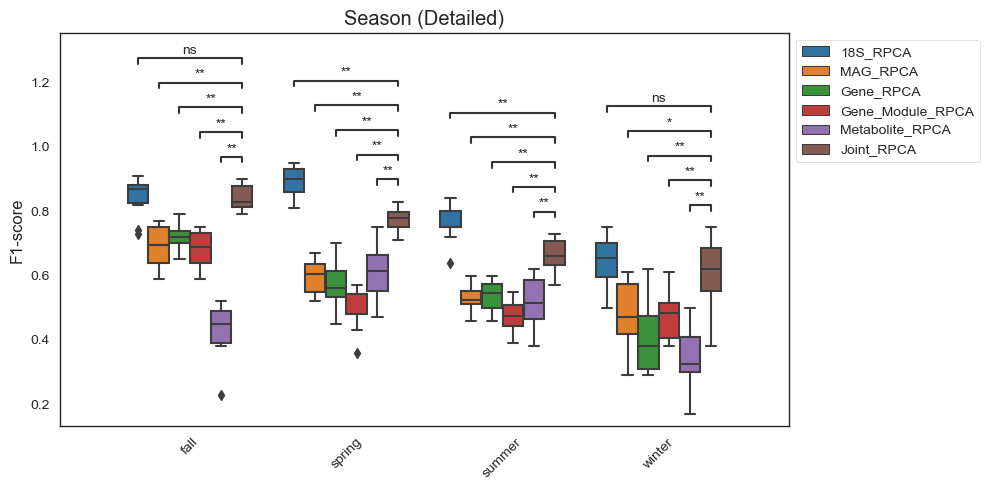

In [60]:
seasons = ["fall", "spring", "summer", "winter"]
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
stat_pairs = [[(season, rpca), (season, "Joint_RPCA")] for
               season in seasons for rpca in rpca_types]

plotting_params = {'x':'Season', 'y':'F1-score', 
                   'palette':'tab10',
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('Season (Detailed)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


## Feature-based classification

In [14]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num += pseudocount
    top_pc_values[component] = num.values
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom += pseudocount
    bottom_pc_values[component] = denom.values
    #calculate trajectories
    beta_ = np.log(num).values - np.log(denom).values
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [15]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [16]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


### Hyper-parameter optimization

In [49]:
#common parameters
quantile = 0.90
pc_to_use = 'PC3'

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [50]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S': ord_18S, 'mag': ord_mag, 'gene': ord_gene, 
            'gene_module': ord_gene_module, 'metabolite': ord_metabolite}

rpca_top_fts = {}
rpca_bottom_fts = {}
rpca_traj = {}

for omic in tables.keys():
    ord_ = rpca_ord[omic].features.copy()
    table_ = tables[omic]
    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    rpca_top_fts[omic] = top_fts
    rpca_bottom_fts[omic] = bottom_fts
    rpca_traj[omic] = beta_l

#find top/bottom features from joint-RPCA results
joint_rpca_top_fts = {}
joint_rpca_bottom_fts = {}
joint_rpca_traj = {}

for omic in tables.keys():
    
    table_ = tables[omic]
    if omic == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    top_fts, bottom_fts, beta_l, _, _ = get_top_features(table_, ord_, component=pc_to_use,
                                                         quantile=quantile, pseudocount=0)
    joint_rpca_top_fts[omic] = top_fts
    joint_rpca_bottom_fts[omic] = bottom_fts
    joint_rpca_traj[omic] = beta_l

In [51]:
#FACILITY
acc_ratio_facility_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                            rpca_traj['gene_module'], rpca_traj['metabolite'],
                                            joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                            joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                                ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                         "Gene_Module_RPCA", "Metabolite_RPCA",
                                         "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                         "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                                shared_mt=metadata, cat_of_interest='facility', ordination=False, 
                                n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6087585034013606
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6193262411347519
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6264489795918367
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6177721088435375
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6065476190476191
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6251700680272109
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5638605442176872
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5819727891156463
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5870748299319727
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5964285714285714
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.6071428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5642857142857143
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.625
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6464285714285715
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6285714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6178571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6321428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7821428571428573
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7642857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7642857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7535714285714287
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7714285714285714
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7785714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.7857142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7678571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5964285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6035714285714285
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6214285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5892857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6142857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.5607142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5892857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6071428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6321428571428571
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.6107142857142858
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857155
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4642857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4714285714285714
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4928571428571429
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.5071428571428572
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4892857142857142
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6916666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6289965986394558
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6791836734693877
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.6427721088435374
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6326530612244897
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6869897959183674
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.6704489795918367
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.6389455782312925
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.653061224489796
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.6304421768707483
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8214285714285714
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8428571428571429
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8321428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8357142857142856
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8428571428571429
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.8
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7892857142857143
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8821428571428571
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8928571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8964285714285714
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.8857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8678571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.875
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8785714285714287
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8892857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8607142857142858
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.8964285714285716
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.8785714285714287
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.47142857142857153
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.48571428571428577
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.48571428571428565
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.47857142857142854


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [52]:
#save results
acc_ratio_facility_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use), index=False)

#read results
#acc_ratio_facility_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_facility_opt.csv'.format(pc_to_use))
display(acc_ratio_facility_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.590361,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
1,18S_RPCA,traintest_1,0.655172,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
2,18S_RPCA,traintest_2,0.571429,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.564706,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
4,18S_RPCA,traintest_4,0.646341,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."


In [53]:
#STAGE OF DECOMPOSITION
acc_ratio_stage_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                         rpca_traj['gene_module'], rpca_traj['metabolite'],
                                         joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                         joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                             ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                      "Gene_Module_RPCA", "Metabolite_RPCA",
                                      "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                      "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                             shared_mt=metadata, cat_of_interest='add_0c_group', ordination=False, 
                             n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4283163265306122
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.47313829787234046
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43387755102040815
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.397874149659864
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4737244897959184
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4291666666666667
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.434608843537415
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.40926870748299315
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4357142857142858
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4892857142857142
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5214285714285715
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.5285714285714287
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.48571428571428565
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5392857142857143
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.5107142857142858
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5178571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.5035714285714287
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.43928571428571433
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.49642857142857144
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4571428571428572
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4714285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45357142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5142857142857142
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.46428571428571425
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4071428571428572
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3916666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4712585034013606
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46636734693877546
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4351190476190476
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.5166666666666667
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4879183673469387
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.4649659863945578
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.47346938775510206
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42023809523809524
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.42142857142857154
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4535714285714286
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4892857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4428571428571429
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.4821428571428572
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4214285714285714
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.48571428571428577
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.46071428571428574
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4107142857142857
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4392857142857142
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.4607142857142857
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4000000000000001
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3857142857142858
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.42857142857142866
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.43571428571428567
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857134


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/biacordazzo/opt/anaconda3/envs/qiime2-am

In [54]:
#save results
acc_ratio_stage_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_stage_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_stage_opt.csv'.format(pc_to_use))
display(acc_ratio_stage_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.421687,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
1,18S_RPCA,traintest_1,0.402299,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': 10, 'min_samp..."
2,18S_RPCA,traintest_2,0.441558,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."
3,18S_RPCA,traintest_3,0.352941,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
4,18S_RPCA,traintest_4,0.463415,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."


In [55]:
#SEASON
acc_ratio_season_opt = rf_acc(ord_tables=[rpca_traj['18S'], rpca_traj['mag'], rpca_traj['gene'],
                                          rpca_traj['gene_module'], rpca_traj['metabolite'],
                                          joint_rpca_traj['18S'], joint_rpca_traj['mag'], joint_rpca_traj['gene'],
                                          joint_rpca_traj['gene_module'], joint_rpca_traj['metabolite']],
                              ord_ids=["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
                                       "Gene_Module_RPCA", "Metabolite_RPCA",
                                       "18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                                       "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"],
                              shared_mt=metadata, cat_of_interest='season', ordination=False, 
                              n_folds=10, random_state=42, optimize=True, param_grid=param_grid)

Optimizing hyperparameters for 18S_RPCA, traintest_0...
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3539965986394558
Optimizing hyperparameters for 18S_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4181737588652482
Optimizing hyperparameters for 18S_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3533877551020408
Optimizing hyperparameters for 18S_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.35688775510204085
Optimizing hyperparameters for 18S_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3852891156462585
Optimizing hyperparameters for 18S_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3697278911564626
Optimizing hyperparameters for 18S_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.3447278911564625
Optimizing hyperparameters for 18S_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3916666666666667
Optimizing hyperparameters for 18S_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.34829931972789113
Optimizing hyperparameters for 18S_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.33877551020408164
Optimizing hyperparameters for MAG_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.4035714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3821428571428571
Optimizing hyperparameters for MAG_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for MAG_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41428571428571426
Optimizing hyperparameters for MAG_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3928571428571429
Optimizing hyperparameters for MAG_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.38571428571428573
Optimizing hyperparameters for MAG_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.36428571428571427
Optimizing hyperparameters for MAG_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3785714285714286
Optimizing hyperparameters for MAG_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for MAG_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.37857142857142856
Optimizing hyperparameters for Gene_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3107142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.32142857142857145
Optimizing hyperparameters for Gene_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for Gene_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3142857142857142
Optimizing hyperparameters for Gene_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29642857142857143
Optimizing hyperparameters for Gene_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.25357142857142856
Optimizing hyperparameters for Gene_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.32857142857142857
Optimizing hyperparameters for Gene_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2785714285714286
Optimizing hyperparameters for Gene_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.26785714285714285
Optimizing hyperparameters for Gene_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.30357142857142855
Optimizing hyperparameters for Gene_Module_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for Gene_Module_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2857142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.2857142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for Gene_Module_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3357142857142857
Optimizing hyperparameters for Gene_Module_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3142857142857143
Optimizing hyperparameters for Gene_Module_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.33214285714285713
Optimizing hyperparameters for Gene_Module_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3178571428571428
Optimizing hyperparameters for Gene_Module_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.30714285714285716
Optimizing hyperparameters for Metabolite_RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Metabolite_RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.42857142857142855
Optimizing hyperparameters for Metabolite_RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Metabolite_RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.45
Optimizing hyperparameters for Metabolite_RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.4178571428571428
Optimizing hyperparameters for Metabolite_RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.42142857142857143
Optimizing hyperparameters for Metabolite_RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.475
Optimizing hyperparameters for Metabolite_RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.46785714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4035714285714286
Optimizing hyperparameters for Metabolite_RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.47857142857142865
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3458333333333333
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.35085034013605443
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3973061224489796
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.4149659863945578
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3387755102040816
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation accuracy: 0.38869047619047625
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.39461224489795915
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.34855442176870743
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3183673469387755
Optimizing hyperparameters for 18S_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3828231292517007
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29642857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3392857142857143
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3821428571428571
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3107142857142857
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.325
Optimizing hyperparameters for MAG_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.31428571428571433
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.3892857142857143
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.36071428571428565
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.37142857142857144
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.35
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.3857142857142858
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.38928571428571435
Optimizing hyperparameters for Gene_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.3464285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2571428571428571
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.29285714285714287
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.33571428571428574
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.26071428571428573
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.3
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.28214285714285714
Optimizing hyperparameters for Gene_Module_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.2785714285714286
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_0...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.41428571428571426
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_1...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy: 0.41785714285714287
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_2...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.44642857142857145
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_3...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.425
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_4...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_5...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.45714285714285713
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_6...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4821428571428571
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_7...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.4142857142857143
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_8...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.41071428571428575
Optimizing hyperparameters for Metabolite_Joint-RPCA, traintest_9...


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best parameters found: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best cross-validation accuracy: 0.4392857142857142


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [56]:
#save results
acc_ratio_season_opt.to_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use), index=False)
#read results
#acc_ratio_season_opt = pd.read_csv('../results/joint-rpca/rf_acc_{}-ratio_season_opt.csv'.format(pc_to_use))
display(acc_ratio_season_opt.head())

,Omic,Fold,Accuracy,Report,Optimization
0,18S_RPCA,traintest_0,0.373494,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s..."
1,18S_RPCA,traintest_1,0.298851,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
2,18S_RPCA,traintest_2,0.298701,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
3,18S_RPCA,traintest_3,0.270588,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': 10, 'min_sam..."
4,18S_RPCA,traintest_4,0.353659,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa..."


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.934e-01 Stat=1.400e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.428e-01 Stat=1.450e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:6.953e-01 Stat=2.300e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wil

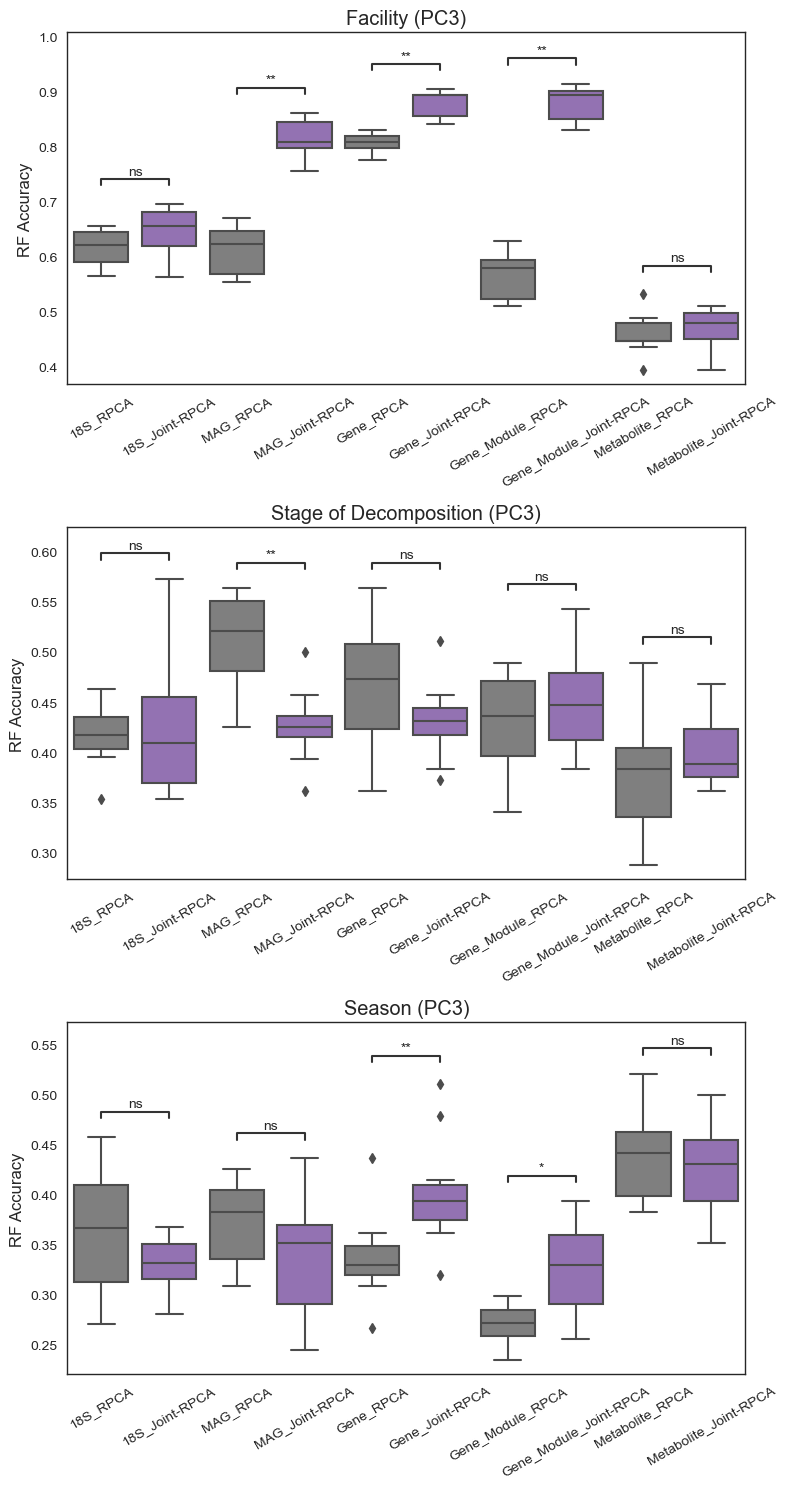

In [57]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(3, 1, figsize=(8, 15))

for ax_, data, title in zip(axn.flatten(), 
                           [acc_ratio_facility_opt, acc_ratio_stage_opt, acc_ratio_season_opt],
                           ['Facility', 'Stage of Decomposition', 'Season']):
    
    plotting_params['data'] = data
    sns.boxplot(ax=ax_, **plotting_params)
    
    ax_.set_xticklabels(ax_.get_xticklabels(), rotation=30)
    ax_.set_xlabel('')
    ax_.set_ylabel('RF Accuracy')
    ax_.set_title('{} ({})'.format(title, pc_to_use))

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

plt.tight_layout()
plt.show()

### Best RPCA PC vs. Best Joint-RPCA PC

In [6]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3']:
        #load results
        acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_opt.csv'.format(pc, task))
        #acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
        #                        sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [7]:
best_pc_per_task = {}
pc_ratio_best = {}

for task in ['facility', 'stage', 'season']:
    print(task)
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

    #store results in dataframe
    pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                              'Report', 'Optimization', 'PC'])

    for omic in result_dict.keys():
        pc_to_use = result_dict[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        pc_ratio_plotting = pc_ratio_plotting._append(pc_ratio_task, ignore_index=True)
    pc_ratio_best[task] = pc_ratio_plotting
    
    display(max_pc_per_omic)
    print()

facility


,Omic,PC,Accuracy
2,18S_Joint-RPCA,PC3,0.656572
3,18S_RPCA,PC1,0.648455
8,Gene_Joint-RPCA,PC3,0.893617
11,Gene_Module_Joint-RPCA,PC3,0.893617
14,Gene_Module_RPCA,PC3,0.579787
17,Gene_RPCA,PC3,0.808511
20,MAG_Joint-RPCA,PC3,0.808511
22,MAG_RPCA,PC2,0.914894
25,Metabolite_Joint-RPCA,PC2,0.500000
27,Metabolite_RPCA,PC1,0.468085



stage


,Omic,PC,Accuracy
1,18S_Joint-RPCA,PC2,0.443152
3,18S_RPCA,PC1,0.445906
7,Gene_Joint-RPCA,PC2,0.484043
9,Gene_Module_Joint-RPCA,PC1,0.478261
12,Gene_Module_RPCA,PC1,0.475921
16,Gene_RPCA,PC2,0.489362
19,MAG_Joint-RPCA,PC2,0.529745
23,MAG_RPCA,PC3,0.521277
24,Metabolite_Joint-RPCA,PC1,0.436170
27,Metabolite_RPCA,PC1,0.414894



season


,Omic,PC,Accuracy
1,18S_Joint-RPCA,PC2,0.496988
4,18S_RPCA,PC2,0.441168
6,Gene_Joint-RPCA,PC1,0.430851
9,Gene_Module_Joint-RPCA,PC1,0.408765
13,Gene_Module_RPCA,PC2,0.393617
15,Gene_RPCA,PC1,0.425532
19,MAG_Joint-RPCA,PC2,0.442606
22,MAG_RPCA,PC2,0.484043
26,Metabolite_Joint-RPCA,PC3,0.430851
29,Metabolite_RPCA,PC3,0.441489


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.309e-01 Stat=1.200e+01
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.325e-01 Stat=1.350e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.750e-01 Stat=1.800e+01


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.219e-01 Stat=2.600e+01
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:9.441e-01 Stat=1.750e+01
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.602e-01 Stat=1.350e+01
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.000e+00 Stat=2.700e+01


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

18S_RPCA vs. 18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
MAG_RPCA vs. MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.000e+00
Gene_RPCA vs. Gene_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.269e-02 Stat=1.500e+00
Gene_Module_RPCA vs. Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.686e-03 Stat=0.000e+00
Metabolite_RPCA vs. Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:5.940e-01 Stat=1.800e+01


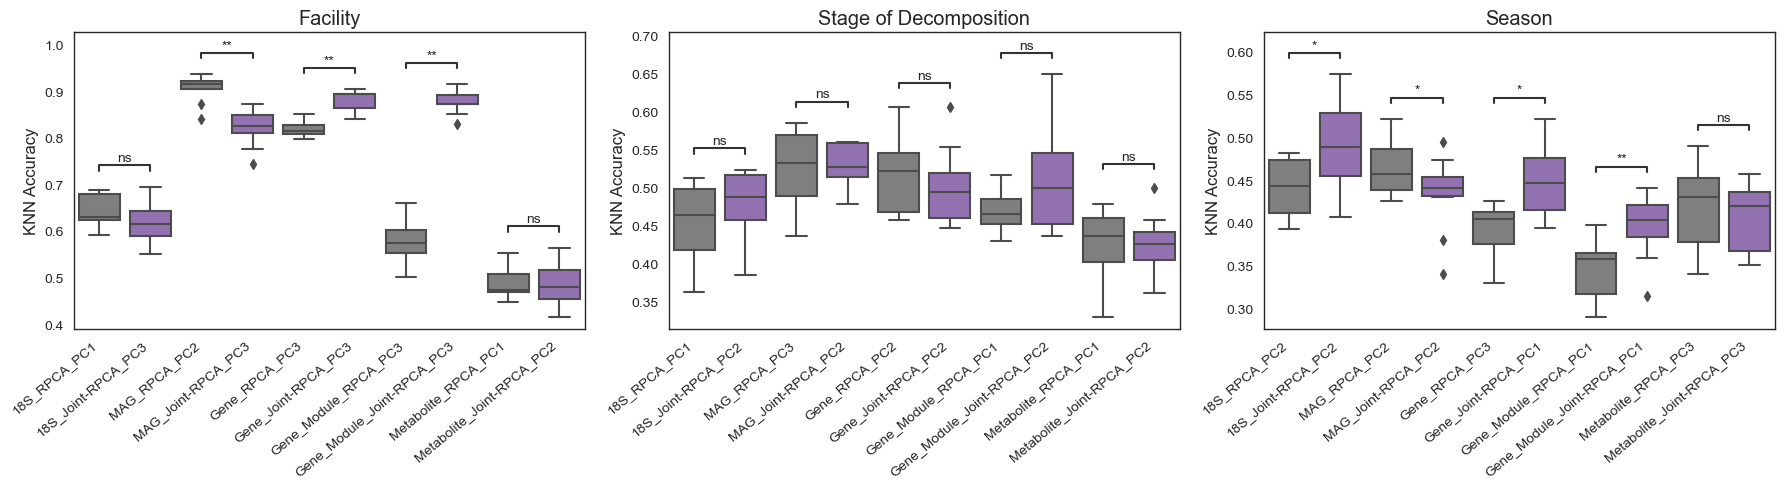

In [52]:
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']

stat_pairs = [('18S_RPCA', '18S_Joint-RPCA'), 
              ('MAG_RPCA', 'MAG_Joint-RPCA'),
              ('Gene_RPCA', 'Gene_Joint-RPCA'), 
              ('Gene_Module_RPCA', 'Gene_Module_Joint-RPCA'),
              ('Metabolite_RPCA', 'Metabolite_Joint-RPCA')]

pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}

plotting_params = {'x':'Omic', 'y':'Accuracy', 
                   'order':order_v1, 'palette':pair_palette}

fig, axn = plt.subplots(1, 3, figsize=(18, 5))

for ax_, task, title in zip(axn.flatten(), 
                            pc_ratio.keys(),
                            ['Facility', 'Stage of Decomposition', 'Season']):
    #get best PC per omic
    best_pc = best_pc_per_task[task]
    rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                                 'Report', 'Optimization', 'PC'])

    for omic in best_pc.keys():
        pc_to_use = best_pc[omic][0]
        #filter out the other PCs
        mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
        rf_pc_ratio_task = pc_ratio[task][mask]
        #append to new df
        rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

    plotting_params['data'] = rf_pc_ratio_plotting
    sns.boxplot(ax=ax_, **plotting_params)

    #add statistical test
    annotator = Annotator(ax_, stat_pairs, **plotting_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()
    #test options: Mann-Whitney, Kruskal, Wilcoxon

    #update x tick labels
    mapping_dict = {}
    for omic, (pc, _) in best_pc_per_task[task].items():
        mapping_dict[omic] = '{}_{}'.format(omic, pc)

    current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
    updated_labels = [mapping_dict.get(label, label) for label in current_labels]

    ax_.set_xticklabels(updated_labels, rotation=40, ha='right')
    ax_.set_xlabel('')
    ax_.set_ylabel('KNN Accuracy')
    ax_.set_title('{}'.format(title))

plt.tight_layout()
plt.show()

### Detailed F1-scores

In [11]:
#get best PC per omic
task = 'facility' #'season', 'facility'
#groups = ['fall', 'spring', 'summer', 'winter'] #for season
groups = ['FIRS', 'STAFS', 'ARF'] #for facility

best_pc = best_pc_per_task[task]
rf_pc_ratio_plotting = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy', 
                                             'Report', 'Optimization', 'PC'])
for omic in best_pc.keys():
    pc_to_use = best_pc[omic][0]
    #filter out the other PCs
    mask = (pc_ratio[task]['Omic'] == omic) & (pc_ratio[task]['PC'] == pc_to_use)
    rf_pc_ratio_task = pc_ratio[task][mask]
    #append to new df
    rf_pc_ratio_plotting = rf_pc_ratio_plotting._append(rf_pc_ratio_task, ignore_index=True)

display(rf_pc_ratio_plotting.head())

,Omic,Fold,Accuracy,Report,Optimization,PC
0,18S_Joint-RPCA,traintest_0,0.563218,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa...",PC3
1,18S_Joint-RPCA,traintest_1,0.658824,precision recall f1-score ...,"{'bootstrap': False, 'max_depth': None, 'min_s...",PC3
2,18S_Joint-RPCA,traintest_2,0.564103,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa...",PC3
3,18S_Joint-RPCA,traintest_3,0.686047,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa...",PC3
4,18S_Joint-RPCA,traintest_4,0.695122,precision recall f1-score ...,"{'bootstrap': True, 'max_depth': None, 'min_sa...",PC3


In [59]:
omic_f1_lst = []
for omic in rf_pc_ratio_plotting.Omic.unique():
    fold_f1_lst = []
    for fold in ['traintest_{}'.format(i) for i in range(10)]:
        #get report for each fold
        fold_report = rf_pc_ratio_plotting[(rf_pc_ratio_plotting.Omic == omic) & 
                                           (rf_pc_ratio_plotting.Fold == fold)].Report.values[0]
        #get each group's F1-score
        group_f1_lst = []
        for g, i in zip(groups, range(2, 6)):
            group_report = fold_report.split('\n')[i].split(' ')
            group_result = [x for x in group_report if len(x)>0][1:]
            group_f1 = [float(x) for x in group_result][2]
            group_f1_lst.append(group_f1)
        fold_f1_lst.extend(group_f1_lst)
    omic_f1_lst.extend(fold_f1_lst)

In [60]:
#create new dataframe with f1 results
omic_lst = [[omic] * 10 * len(groups) for omic in rf_pc_ratio_plotting.Omic.unique()]
omic_lst = np.concatenate(omic_lst)
fold = [['traintest_{}'.format(i)] * len(groups) for i in range(10)] * 10
fold = np.concatenate(fold)
group_lst = groups * 100

f1_df = pd.DataFrame({'Omic': omic_lst, 'Fold': fold, 
                      'Group': group_lst, 'F1-score': omic_f1_lst})
f1_df.head()

,Omic,Fold,Group,F1-score
0,18S_Joint-RPCA,traintest_0,FIRS,0.70
1,18S_Joint-RPCA,traintest_0,STAFS,0.54
2,18S_Joint-RPCA,traintest_0,ARF,0.27
3,18S_Joint-RPCA,traintest_1,FIRS,0.74
4,18S_Joint-RPCA,traintest_1,STAFS,0.48


/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/biacordazzo/opt/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ARF_Metabolite_RPCA vs. ARF_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.723e-01 Stat=1.100e+01
STAFS_Gene_Module_RPCA vs. STAFS_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.906e-03 Stat=1.000e+00
ARF_MAG_RPCA vs. ARF_MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_Gene_Module_RPCA vs. FIRS_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_Metabolite_RPCA vs. FIRS_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:3.424e-01 Stat=1.450e+01
STAFS_MAG_RPCA vs. STAFS_MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=0.000e+00
FIRS_18S_RPCA vs. FIRS_18S_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.414e-02 Stat=3.500e+00
FIRS_MAG_RPCA vs. FIRS_MAG_Joint-R

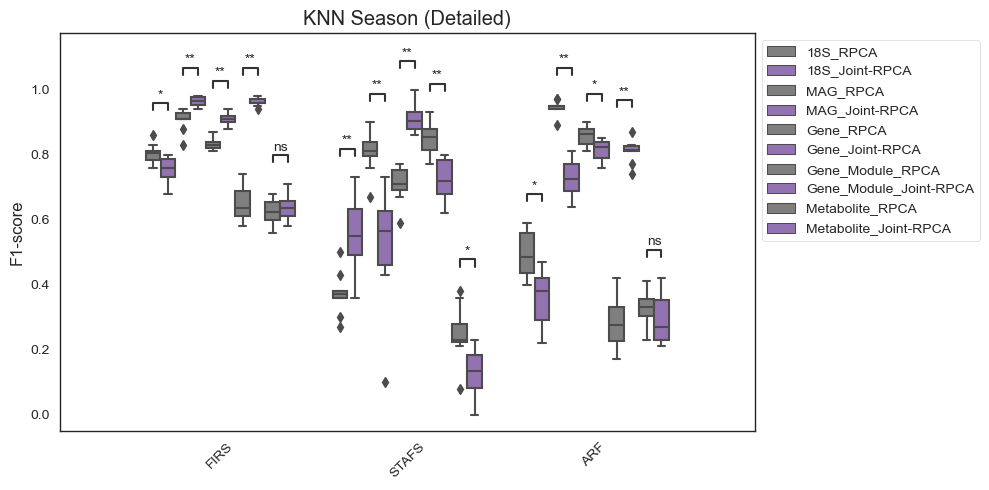

In [61]:
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
plotting_params = {'x':'Group', 'y':'F1-score', 
                   'palette':pair_palette, 'hue_order':order_v1,
                   'data':f1_df, 'hue':'Omic'}

#seaborn boxplot of individual AUC_APRs without stat test
plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#x axis rotation
ax_.set_xticklabels(ax_.get_xticklabels(), rotation=45)
ax_.set_xlabel('')
ax_.set_ylabel('F1-score')
ax_.set_title('KNN Season (Detailed)')
#plot legend outside of box
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Decomposer Network

In [ ]:
#create dict with best PC per omic, based on KW results
best_pc_per_task_kw = {'stage_minus_facility': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC2',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC3',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC1'},
                        'stage_minus_season': {'18S_Joint-RPCA': 'PC2',
                                                '18S_RPCA': 'PC3',
                                                'Gene_Joint-RPCA': 'PC2',
                                                'Gene_Module_RPCA': 'PC2',
                                                'Gene_Module_Joint-RPCA': 'PC2',
                                                'Gene_RPCA': 'PC2',
                                                'MAG_Joint-RPCA': 'PC2',
                                                'MAG_RPCA': 'PC3',
                                                'Metabolite_Joint-RPCA': 'PC2',
                                                'Metabolite_RPCA': 'PC3'},
                        'stage_minus_both': {'18S_Joint-RPCA': 'PC2',
                                             '18S_RPCA': 'PC3',
                                             'Gene_Joint-RPCA': 'PC2',
                                             'Gene_Module_RPCA': 'PC2',
                                             'Gene_Module_Joint-RPCA': 'PC2',
                                             'Gene_RPCA': 'PC2',
                                             'MAG_Joint-RPCA': 'PC2',
                                             'MAG_RPCA': 'PC3',
                                             'Metabolite_Joint-RPCA': 'PC2',
                                             'Metabolite_RPCA': 'PC3'}}

In [23]:
acc_task = {}
for diff in best_pc_per_task_kw.keys():
    
    acc_omic = {}
    for omic in best_pc_per_task_kw[diff].keys():
        pc_to_use = best_pc_per_task_kw[diff][omic]

        #keep relevant PCs for each classification task
        mask = (pc_ratio['facility']['Omic'] == omic) & (pc_ratio['facility']['PC'] == pc_to_use)
        pc_ratio_facility = pc_ratio['facility'][mask]

        mask = (pc_ratio['stage']['Omic'] == omic) & (pc_ratio['stage']['PC'] == pc_to_use)
        pc_ratio_stage = pc_ratio['stage'][mask]

        mask = (pc_ratio['season']['Omic'] == omic) & (pc_ratio['season']['PC'] == pc_to_use)
        pc_ratio_season = pc_ratio['season'][mask]

        #calculate differences in accuracy for each fold
        acc_fold = []
        for fold in ['traintest_{}'.format(i) for i in range(10)]:

            stage_acc = pc_ratio_stage[pc_ratio_stage.Fold == fold].Accuracy.values[0]
            
            if diff == 'stage_minus_facility':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - facility_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_season':
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - season_acc
                acc_fold.append(diff_)
            
            elif diff == 'stage_minus_both':
                facility_acc = pc_ratio_facility[pc_ratio_facility.Fold == fold].Accuracy.values[0]
                season_acc = pc_ratio_season[pc_ratio_season.Fold == fold].Accuracy.values[0]
                diff_ = stage_acc - (facility_acc + season_acc)
                acc_fold.append(diff_)

        acc_omic[omic] = acc_fold
    acc_task[diff] = acc_omic

In [28]:
diff_df = pd.DataFrame(columns=['Omic', 'Fold', 'Difference', 'Task'])
for task, omic_dict in acc_task.items():
    for omic, values in omic_dict.items():
        for fold, value in zip(['traintest_{}'.format(i) for i in range(10)], values):
            diff_df = diff_df._append({'Omic': omic, 'Fold': fold, 
                                       'Difference': value, 'Task': task}, ignore_index=True)
#sanity check  
display(diff_df)

,Omic,Fold,Difference,Task
0,18S_Joint-RPCA,traintest_0,-0.081395,stage_minus_facility
1,18S_Joint-RPCA,traintest_1,-0.147727,stage_minus_facility
2,18S_Joint-RPCA,traintest_2,-0.049383,stage_minus_facility
3,18S_Joint-RPCA,traintest_3,-0.011765,stage_minus_facility
4,18S_Joint-RPCA,traintest_4,-0.085366,stage_minus_facility
...,...,...,...,...
295,Metabolite_RPCA,traintest_5,-0.489362,stage_minus_both
296,Metabolite_RPCA,traintest_6,-0.436170,stage_minus_both
297,Metabolite_RPCA,traintest_7,-0.425532,stage_minus_both
298,Metabolite_RPCA,traintest_8,-0.617021,stage_minus_both


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

stage_minus_both_Metabolite_RPCA vs. stage_minus_both_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:2.734e-02 Stat=6.000e+00
stage_minus_season_Gene_Module_RPCA vs. stage_minus_season_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:4.883e-02 Stat=8.500e+00
stage_minus_both_MAG_RPCA vs. stage_minus_both_MAG_Joint-RPCA: Wilcoxon test (paired samples), P_val:5.566e-01 Stat=2.100e+01
stage_minus_facility_Gene_Module_RPCA vs. stage_minus_facility_Gene_Module_Joint-RPCA: Wilcoxon test (paired samples), P_val:7.695e-01 Stat=2.350e+01
stage_minus_facility_Metabolite_RPCA vs. stage_minus_facility_Metabolite_Joint-RPCA: Wilcoxon test (paired samples), P_val:8.457e-01 Stat=2.550e+01
stage_minus_season_MAG_RPCA vs. stage_minus_season_MAG_Joint-RPCA: Wilcoxon test (paired samples),

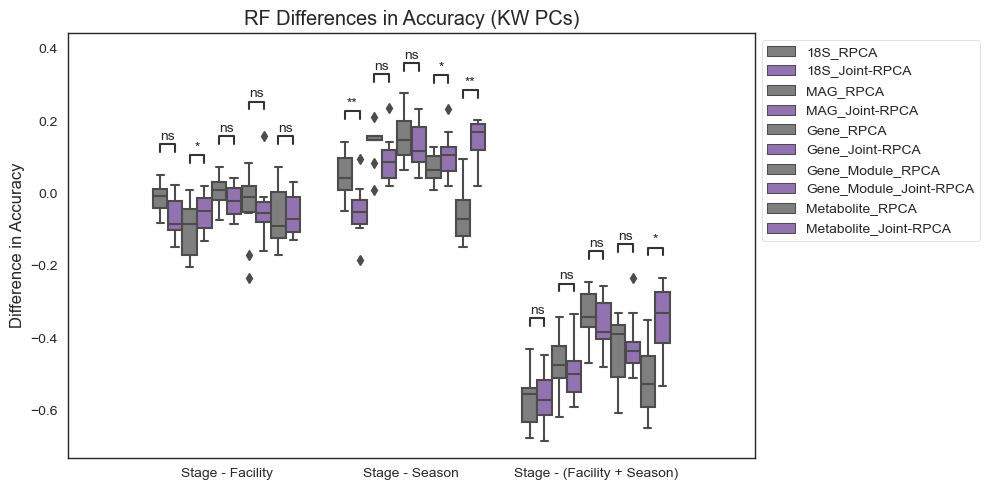

In [30]:
#barplot of differences
rpca_types = ["18S_RPCA", "MAG_RPCA", "Gene_RPCA", 
              "Gene_Module_RPCA", "Metabolite_RPCA"]
joint_rpca_types = ["18S_Joint-RPCA", "MAG_Joint-RPCA", "Gene_Joint-RPCA", 
                    "Gene_Module_Joint-RPCA", "Metabolite_Joint-RPCA"]
order_v1 = ['18S_RPCA', '18S_Joint-RPCA', 
            'MAG_RPCA', 'MAG_Joint-RPCA',
            'Gene_RPCA', 'Gene_Joint-RPCA', 
            'Gene_Module_RPCA', 'Gene_Module_Joint-RPCA',
            'Metabolite_RPCA', 'Metabolite_Joint-RPCA']
pair_palette = {'18S_RPCA': 'tab:grey', '18S_Joint-RPCA': 'tab:purple',
                'MAG_RPCA': 'tab:grey', 'MAG_Joint-RPCA': 'tab:purple',
                'Gene_RPCA': 'tab:grey', 'Gene_Joint-RPCA': 'tab:purple',
                'Gene_Module_RPCA': 'tab:grey', 'Gene_Module_Joint-RPCA': 'tab:purple',
                'Metabolite_RPCA': 'tab:grey', 'Metabolite_Joint-RPCA': 'tab:purple'}
groups = diff_df.Task.unique()
stat_pairs = [[(g, rpca1), (g, rpca2)] for
               g in groups for rpca1, rpca2 in 
               zip(rpca_types, joint_rpca_types)]
plotting_params = {'x':'Task', 'y':'Difference', 
                   'data':diff_df, 'palette':pair_palette,
                   'hue':'Omic', 'hue_order':order_v1,
                   'order': groups}

plt.figure(figsize=(10, 5))
ax_ = plt.gca()
sns.boxplot(ax=ax_, **plotting_params)

#add statistical test
annotator = Annotator(ax_, stat_pairs, **plotting_params)
annotator.configure(test="Wilcoxon").apply_and_annotate()
#test options: Mann-Whitney, Kruskal, Wilcoxon

#update x labels
current_labels = [tick.get_text() for tick in ax_.get_xticklabels()]
updated_labels = ['Stage - Facility', 'Stage - Season', 
                  'Stage - (Facility + Season)']
ax_.set_xticklabels(updated_labels)
#x axis rotation
ax_.set_xlabel('')
ax_.set_ylabel('Difference in Accuracy')
ax_.set_title('RF Differences in Accuracy (KW PCs)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()